# HEOM 1a: Spin-Bath model (introduction)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its
environment, the latter of which is encoded in a set of auxiliary density
matrices.

In this example we show the evolution of a single two-level system in contact
with a single Bosonic environment.  The properties of the system are encoded
in a Hamiltonian, and a coupling operator which describes how it is coupled
to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz
Spectral Density, commonly used with the HEOM. We show how to do this using
the Matsubara, Pade and fitting decompositions, and compare their
convergence.

### Drude-Lorentz (overdamped) spectral density

The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off
frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \
       \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral
density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) \
               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \} \
               & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import qutip
from qutip import (
    basis,
    brmesolve,
    destroy,
    expect,
    liouvillian,
    qeye,
    sigmax,
    sigmaz,
    spost,
    spre,
    tensor,
)

from qutip.solver.heom import (
    BosonicBath,
    DrudeLorentzBath,
    DrudeLorentzPadeBath,
    HEOMSolver,
    HSolverDL,
)

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """Vectorized cotangent of x."""
    return 1.0 / np.tan(x)

In [3]:
def dl_matsubara_params(lam, gamma, T, nk):
    """Calculation of the real and imaginary expansions of the Drude-Lorenz
    correlation functions.
    """
    ckAR = [lam * gamma * cot(gamma / (2 * T))]
    ckAR.extend(
        4
        * lam
        * gamma
        * T
        * 2
        * np.pi
        * k
        * T
        / ((2 * np.pi * k * T) ** 2 - gamma**2)
        for k in range(1, nk + 1)
    )
    vkAR = [gamma]
    vkAR.extend(2 * np.pi * k * T for k in range(1, nk + 1))

    ckAI = [lam * gamma * (-1.0)]
    vkAI = [gamma]

    return ckAR, vkAR, ckAI, vkAI

In [4]:
def dl_corr_approx(t, nk):
    """Drude-Lorenz correlation function approximation.

    Approximates the correlation function at each time t to nk exponents.
    """
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2)) * np.exp(
            -vk * t
        )
    return c

In [5]:
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result, measurement_operation,
    color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [6]:
@contextlib.contextmanager
def timer(label):
    """Simple utility for timing functions:

    with timer("name"):
        ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [7]:
# Default solver options:

default_options = {
    "nsteps": 1500,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [8]:
# Defining the system Hamiltonian
eps = 0.5  # Energy of the 2-level system.
Del = 1.0  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [9]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [10]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz()  # coupling operator

# Bath properties:
gamma = 0.5  # cut off frequency
lam = 0.1  # coupling strength
T = 0.5
beta = 1.0 / T

# HEOM parameters
NC = 5  # cut off parameter for the bath
Nk = 2  # terms in the Matsubara expansion of the correlation function

# Times to solve for
tlist = np.linspace(0, 50, 1000)

In [11]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### First of all, it is useful to look at the spectral density

Now we are ready to begin. Let's look at the shape of the spectral density given the bath parameters we defined above:

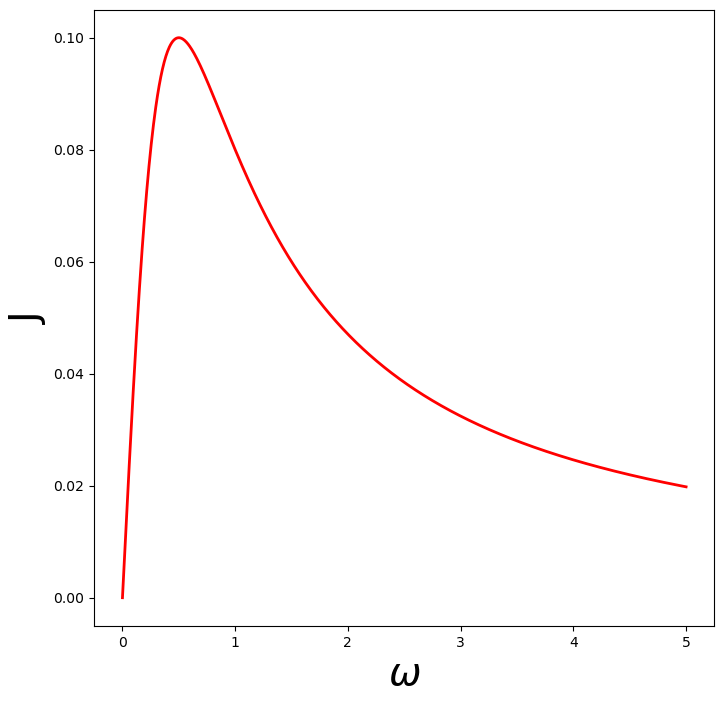

In [12]:
def plot_spectral_density():
    """Plot the Drude-Lorentz spectral density"""
    w = np.linspace(0, 5, 1000)
    J = w * 2 * lam * gamma / (gamma**2 + w**2)

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, J, "r", linewidth=2)
    axes.set_xlabel(r"$\omega$", fontsize=28)
    axes.set_ylabel(r"J", fontsize=28)


plot_spectral_density()

Next we calculate the exponents using the Matsubara decompositions. Here we
split them into real and imaginary parts.

The HEOM code will optimize these, and reduce the number of exponents when
real and imaginary parts have the same exponent. This is clearly the case
for the first term in the vkAI and vkAR lists.

In [13]:
ckAR, vkAR, ckAI, vkAI = dl_matsubara_params(nk=Nk, lam=lam, gamma=gamma, T=T)

Having created the lists which specify the bath correlation functions, we
create a `BosonicBath` from them and pass the bath to the `HEOMSolver` class.

The solver constructs the "right hand side" (RHS) determinining how the
system and auxiliary density operators evolve in time. This can then be used
to solve for dynamics or steady-state.

Below we create the bath and solver and then solve for the dynamics by
calling `.run(rho0, tlist)`.

In [14]:
options = {**default_options}

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMMats = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.009456396102905273
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 Total run time:   0.62s
ODE solver time: 0.6188397407531738


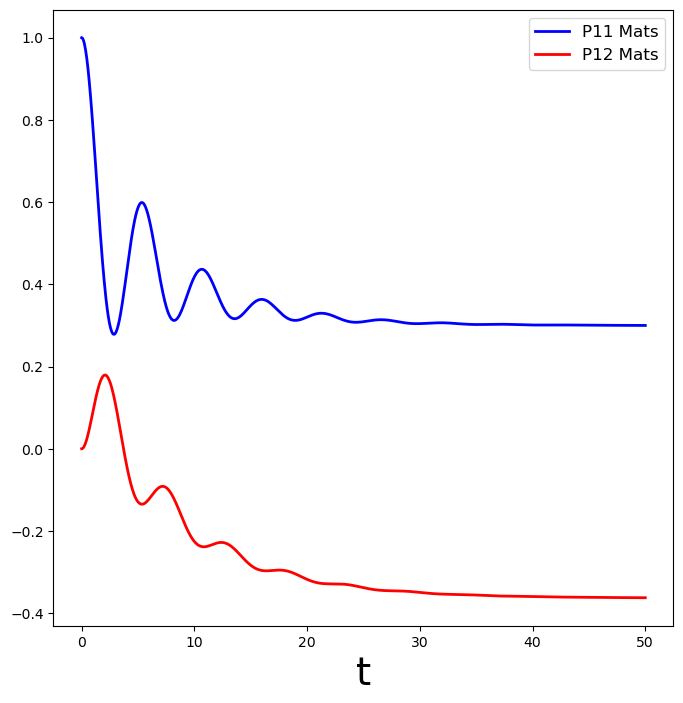

In [15]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
    ]
);

In practice, one would not perform this laborious expansion for the
Drude-Lorentz correlation function, because QuTiP already has a class,
`DrudeLorentzBath`, that can construct this bath for you. Nevertheless,
knowing how to perform this expansion will allow you to construct your own
baths for other spectral densities.

Below we show how to use this built-in functionality:

In [16]:
# Compare to built-in Drude-Lorentz bath:

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOM_dlbath = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlbath = HEOM_dlbath.run(rho0, tlist)  # normal  115

RHS construction time: 0.008582830429077148
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.58s / Remaining 00:00:00:00

 Total run time:   0.58s
ODE solver time: 0.5815243721008301


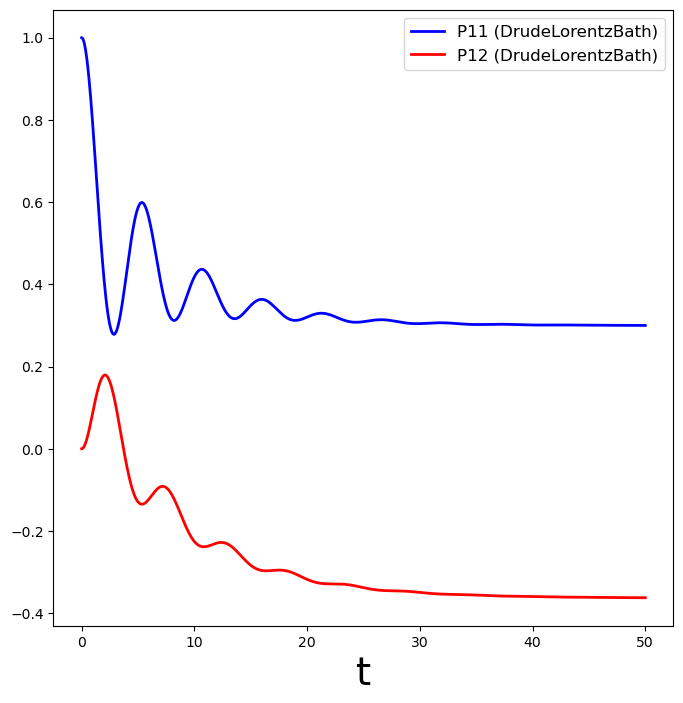

In [17]:
plot_result_expectations(
    [
        (result_dlbath, P11p, "b", "P11 (DrudeLorentzBath)"),
        (result_dlbath, P12p, "r", "P12 (DrudeLorentzBath)"),
    ]
);

We also provide a legacy class, `HSolverDL`, which calculates the
Drude-Lorentz correlation functions automatically, to be backwards
compatible with the previous HEOM solver in QuTiP:

In [18]:
# Compare to legacy class:

# The legacy class performs the above collation of coefficients automatically,
# based upon the parameters for the Drude-Lorentz spectral density.

with timer("RHS construction time"):
    HEOMlegacy = HSolverDL(Hsys, Q, lam, T, NC, Nk, gamma, options=options)

with timer("ODE solver time"):
    resultLegacy = HEOMlegacy.run(rho0, tlist)  # normal  115

RHS construction time: 0.004677534103393555
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 Total run time:   0.49s
ODE solver time: 0.4884169101715088


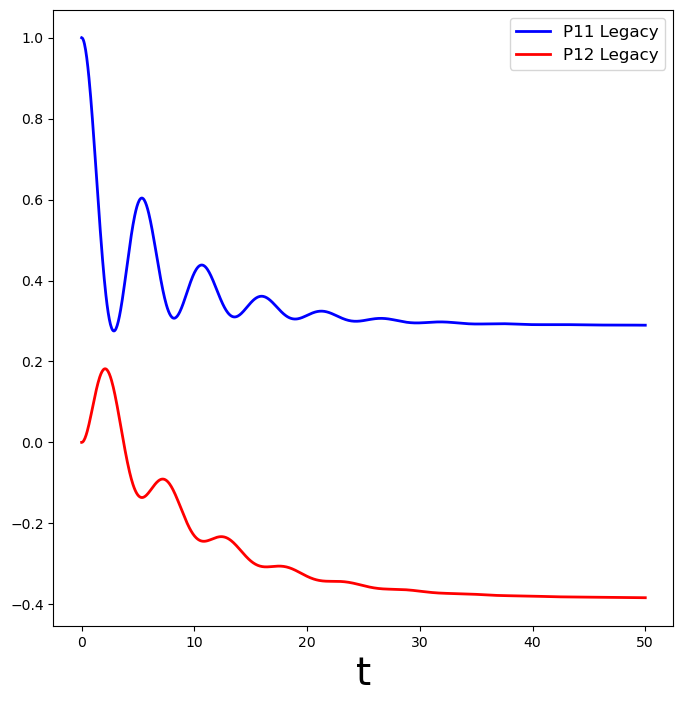

In [19]:
plot_result_expectations(
    [
        (resultLegacy, P11p, "b", "P11 Legacy"),
        (resultLegacy, P12p, "r", "P12 Legacy"),
    ]
);

## Ishizaki-Tanimura Terminator

To speed up convergence (in terms of the number of exponents kept in the
Matsubara decomposition), We can treat the $Re[C(t=0)]$ component as a
delta-function distribution, and include it as Lindblad correction. This is
sometimes known as the Ishizaki-Tanimura Terminator.

In more detail, given

\begin{equation*}
C(t)=\sum_{k=0}^{\infty} c_k e^{-\nu_k t}
\end{equation*}

since $\nu_k=\frac{2 \pi k}{\beta }$, if $1/\nu_k$ is much much smaller than
other important time-scales, we can approximate,
$ e^{-\nu_k t} \approx \delta(t)/\nu_k$, and $C(t)=\sum_{k=N_k}^{\infty}
\frac{c_k}{\nu_k} \delta(t)$

It is convenient to calculate the whole sum
$ C(t)=\sum_{k=0}^{\infty} \frac{c_k}{\nu_k} =  2 \lambda / (\beta \gamma)
- i\lambda $
, and subtract off the contribution from the finite number of Matsubara terms
that are kept in the hierarchy, and treat the residual as a Lindblad.

This is clearer if we plot the correlation function with a large number of
Matsubara terms:

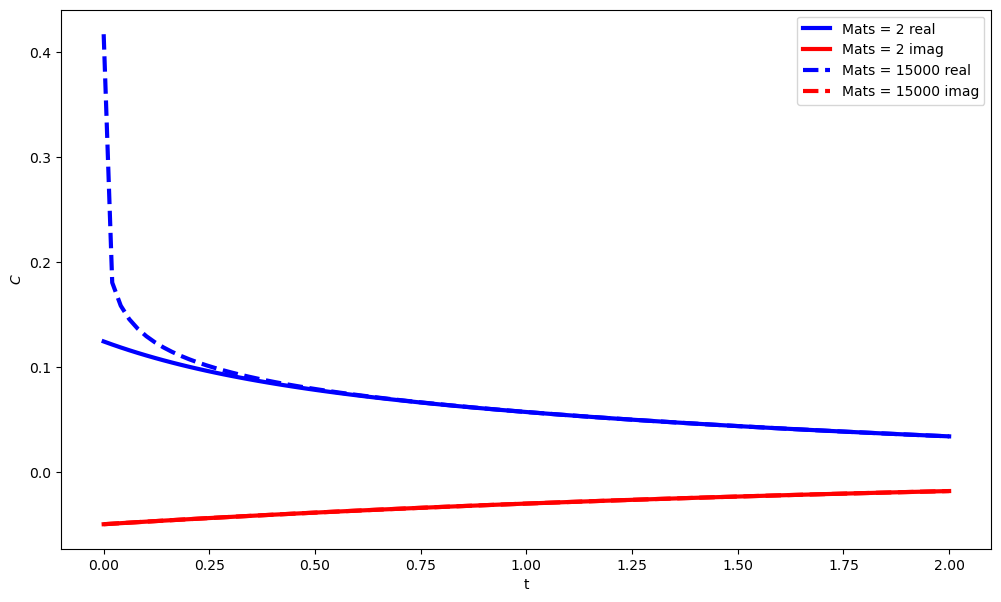

In [20]:
def plot_correlation_expansion_divergence():
    """We plot the correlation function with a large number of Matsubara terms
    to show that the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 2, 100)

    # correlation coefficients with 15k and 2 terms
    corr_15k = dl_corr_approx(t, 15_000)
    corr_2 = dl_corr_approx(t, 2)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(
        t, np.real(corr_2), color="b", linewidth=3, label=r"Mats = 2 real"
    )
    ax1.plot(
        t, np.imag(corr_2), color="r", linewidth=3, label=r"Mats = 2 imag"
    )
    ax1.plot(
        t, np.real(corr_15k), "b--", linewidth=3, label=r"Mats = 15000 real"
    )
    ax1.plot(
        t, np.imag(corr_15k), "r--", linewidth=3, label=r"Mats = 15000 imag"
    )

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()


plot_correlation_expansion_divergence();

Let us evaluate the result including this Ishizaki-Tanimura terminator:

In [21]:
# Run HEOM solver and include the Ishizaki-Tanimura terminator

# Notes:
#
# * when using the built-in DrudeLorentzBath, the terminator (L_bnd) is
#   available from bath.terminator().
#
# * in the legacy HSolverDL function the terminator is included automatically
#   if the parameter bnd_cut_approx=True is used.

op = -2 * spre(Q) * spost(Q.dag()) + spre(Q.dag() * Q) + spost(Q.dag() * Q)

approx_factr = (2 * lam / (beta * gamma)) - 1j * lam

approx_factr -= lam * gamma * (-1.0j + cot(gamma / (2 * T))) / gamma
for k in range(1, Nk + 1):
    vk = 2 * np.pi * k * T

    approx_factr -= (4 * lam * gamma * T * vk / (vk**2 - gamma**2)) / vk

L_bnd = -approx_factr * op

Ltot = -1.0j * (spre(Hsys) - spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMMatsT = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.008194684982299805
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.71s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.71s / Remaining 00:00:00:00

 Total run time:   0.71s
ODE solver time: 0.7103407382965088


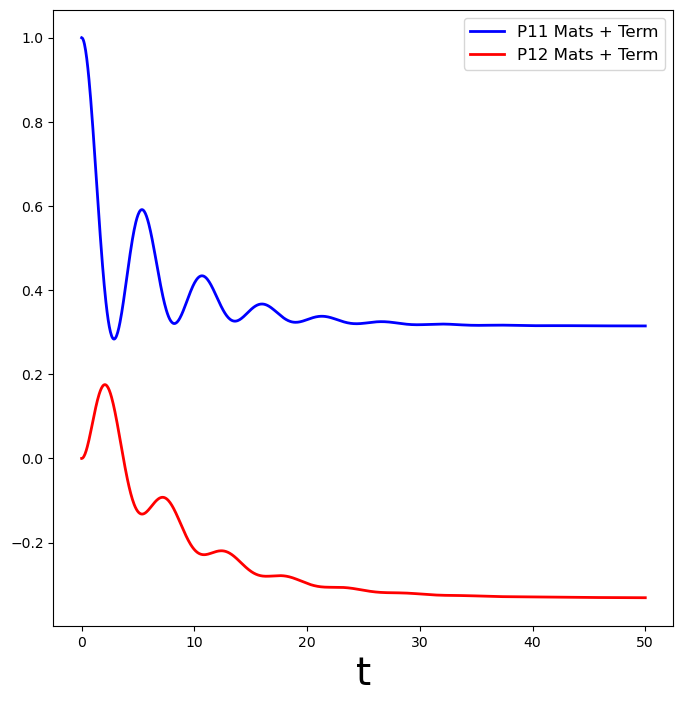

In [22]:
plot_result_expectations(
    [
        (resultMatsT, P11p, "b", "P11 Mats + Term"),
        (resultMatsT, P12p, "r", "P12 Mats + Term"),
    ]
);

Or using the built-in Drude-Lorentz bath we can write simply:

In [23]:
options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOM_dlbath_T = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlbath_T = HEOM_dlbath_T.run(rho0, tlist)

RHS construction time: 0.01082754135131836


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.62s / Remaining 00:00:00:00

 Total run time:   0.62s
ODE solver time: 0.6172881126403809


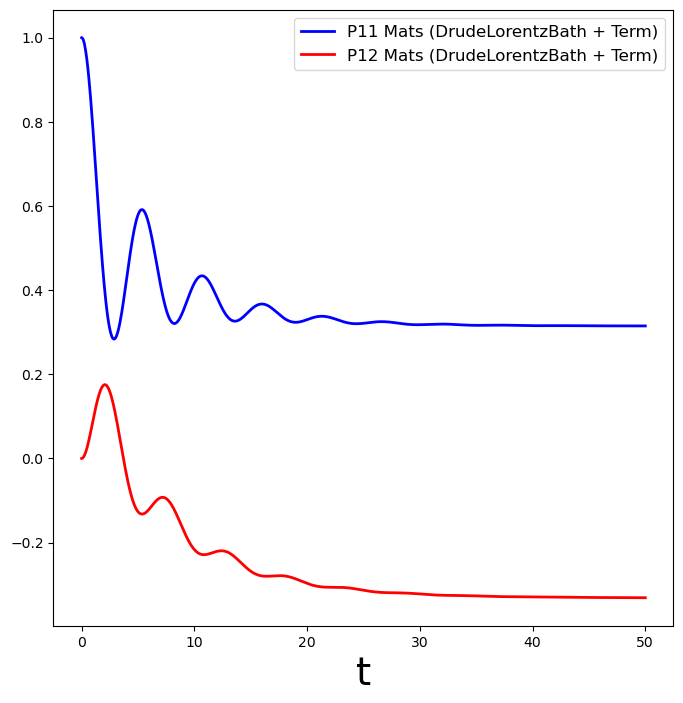

In [24]:
plot_result_expectations(
    [
        (result_dlbath_T, P11p, "b", "P11 Mats (DrudeLorentzBath + Term)"),
        (result_dlbath_T, P12p, "r", "P12 Mats (DrudeLorentzBath + Term)"),
    ]
);

We can compare the solution obtained from the QuTiP Bloch-Redfield solver:

In [25]:
DL = (
    f"2*pi* 2.0 * {lam} / (pi * {gamma} * {beta}) if (w == 0) else "
    f"2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) "
    f"* ((1/(exp((w) * {beta})-1))+1)"
)
options = {**default_options}

with timer("ODE solver time"):
    resultBR = brmesolve(
        Hsys, rho0, tlist, a_ops=[[sigmaz(), DL]], options=options
    )

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.07s / Remaining 00:00:00:06

 [          1%           ] Elapsed 0.07s / Remaining 00:00:00:07

 [          1%           ] Elapsed 0.08s / Remaining 00:00:00:07

 [          1%           ] Elapsed 0.09s / Remaining 00:00:00:08

 [          1%           ] Elapsed 0.10s / Remaining 00:00:00:10

 [          1%           ] Elapsed 0.11s / Remaining 00:00:00:10

 [          1%           ] Elapsed 0.12s / Remaining 00:00:00:11

 [          1%           ] Elapsed 0.12s / Remaining 00:00:00:12

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          2%           ] Elapsed 0.15s / Remaining 00:00:00:07

 [          2%           ] Elapsed 0.15s / Remaining 00:00:00:07

 [          2%           ] Elapsed 0.16s / Remaining 00:00:00:07

 [          2%           ] Elapsed 0.17s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.20s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.21s / Remaining 00:00:00:10

 [          2%           ] Elapsed 0.22s / Remaining 00:00:00:10

 [          2%           ] Elapsed 0.23s / Remaining 00:00:00:11

 [*         3%           ] Elapsed 0.24s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.24s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.25s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.27s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.28s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.28s / Remaining 00:00:00:09

 [*         3%           ] Elapsed 0.29s / Remaining 00:00:00:09

 [*         3%           ] Elapsed 0.30s / Remaining 00:00:00:09

 [*         3%           ] Elapsed 0.32s / Remaining 00:00:00:10

 [*         3%           ] Elapsed 0.32s / Remaining 00:00:00:10

 [*         4%           ] Elapsed 0.33s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.34s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.36s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.37s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.37s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.38s / Remaining 00:00:00:09

 [*         4%           ] Elapsed 0.39s / Remaining 00:00:00:09

 [*         4%           ] Elapsed 0.40s / Remaining 00:00:00:09

 [*         4%           ] Elapsed 0.41s / Remaining 00:00:00:09

 [*         4%           ] Elapsed 0.42s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.43s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.43s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.45s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.46s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.47s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.47s / Remaining 00:00:00:08

 [*         5%           ] Elapsed 0.48s / Remaining 00:00:00:09

 [*         5%           ] Elapsed 0.50s / Remaining 00:00:00:09

 [*         5%           ] Elapsed 0.50s / Remaining 00:00:00:09

 [*         5%           ] Elapsed 0.51s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.52s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.54s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.54s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.55s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.56s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.56s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.58s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.58s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.60s / Remaining 00:00:00:09

 [**        7%           ] Elapsed 0.60s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.63s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.64s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.64s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.65s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.67s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.67s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.68s / Remaining 00:00:00:09

 [**        7%           ] Elapsed 0.69s / Remaining 00:00:00:09

 [**        8%           ] Elapsed 0.69s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.71s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.72s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.72s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.73s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.74s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.76s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.76s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.77s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.78s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.79s / Remaining 00:00:00:07

 [**        9%           ] Elapsed 0.80s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.81s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.82s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.82s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.83s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.85s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.85s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.86s / Remaining 00:00:00:08

 [**        9%           ] Elapsed 0.87s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.88s / Remaining 00:00:00:07

 [**       10%           ] Elapsed 0.89s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.90s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.91s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.91s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.92s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.94s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.94s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.95s / Remaining 00:00:00:08

 [**       10%           ] Elapsed 0.96s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 0.97s / Remaining 00:00:00:07

 [***      11%           ] Elapsed 0.98s / Remaining 00:00:00:07

 [***      11%           ] Elapsed 0.99s / Remaining 00:00:00:07

 [***      11%           ] Elapsed 1.00s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.00s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.01s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.03s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.03s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.04s / Remaining 00:00:00:08

 [***      11%           ] Elapsed 1.05s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.06s / Remaining 00:00:00:07

 [***      12%           ] Elapsed 1.07s / Remaining 00:00:00:07

 [***      12%           ] Elapsed 1.08s / Remaining 00:00:00:07

 [***      12%           ] Elapsed 1.09s / Remaining 00:00:00:07

 [***      12%           ] Elapsed 1.09s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.10s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.12s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.13s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.13s / Remaining 00:00:00:08

 [***      12%           ] Elapsed 1.14s / Remaining 00:00:00:08

 [***      13%           ] Elapsed 1.15s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.17s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.17s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.18s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.19s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.19s / Remaining 00:00:00:07

 [***      13%           ] Elapsed 1.21s / Remaining 00:00:00:08

 [***      13%           ] Elapsed 1.22s / Remaining 00:00:00:08

 [***      13%           ] Elapsed 1.22s / Remaining 00:00:00:08

 [***      13%           ] Elapsed 1.23s / Remaining 00:00:00:08

 [***      14%           ] Elapsed 1.24s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.25s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.26s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.27s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.28s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.29s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.29s / Remaining 00:00:00:07

 [***      14%           ] Elapsed 1.31s / Remaining 00:00:00:08

 [***      14%           ] Elapsed 1.32s / Remaining 00:00:00:08

 [***      14%           ] Elapsed 1.32s / Remaining 00:00:00:08

 [***      15%           ] Elapsed 1.33s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.34s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.35s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.36s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.37s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.37s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.38s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.39s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.41s / Remaining 00:00:00:07

 [***      15%           ] Elapsed 1.41s / Remaining 00:00:00:08

 [****     16%           ] Elapsed 1.42s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.43s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.44s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.45s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.46s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.47s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.48s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.49s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.49s / Remaining 00:00:00:07

 [****     16%           ] Elapsed 1.51s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.52s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.52s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.53s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.54s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.55s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.56s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.57s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.58s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.59s / Remaining 00:00:00:07

 [****     17%           ] Elapsed 1.59s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.61s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.62s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.63s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.63s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.64s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.66s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.66s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.67s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.68s / Remaining 00:00:00:07

 [****     18%           ] Elapsed 1.68s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.69s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.71s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.72s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.72s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.73s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.74s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.75s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.76s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.76s / Remaining 00:00:00:07

 [****     19%           ] Elapsed 1.77s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.78s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.79s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.80s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.81s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.82s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.82s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.83s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.84s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.85s / Remaining 00:00:00:07

 [*****    20%           ] Elapsed 1.86s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.87s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.88s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.88s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.90s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.91s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.91s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.92s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.93s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.94s / Remaining 00:00:00:07

 [*****    21%           ] Elapsed 1.95s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 1.96s / Remaining 00:00:00:06

 [*****    22%           ] Elapsed 1.97s / Remaining 00:00:00:06

 [*****    22%           ] Elapsed 1.97s / Remaining 00:00:00:06

 [*****    22%           ] Elapsed 1.98s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 1.99s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 2.01s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 2.01s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 2.02s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 2.03s / Remaining 00:00:00:07

 [*****    22%           ] Elapsed 2.04s / Remaining 00:00:00:07

 [*****    23%           ] Elapsed 2.04s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.06s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.07s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.07s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.08s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.09s / Remaining 00:00:00:06

 [*****    23%           ] Elapsed 2.10s / Remaining 00:00:00:07

 [*****    23%           ] Elapsed 2.11s / Remaining 00:00:00:07

 [*****    23%           ] Elapsed 2.12s / Remaining 00:00:00:07

 [*****    23%           ] Elapsed 2.13s / Remaining 00:00:00:07

 [******   24%           ] Elapsed 2.14s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.14s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.15s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.17s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.18s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.18s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.19s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.20s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.21s / Remaining 00:00:00:06

 [******   24%           ] Elapsed 2.23s / Remaining 00:00:00:07

 [******   25%           ] Elapsed 2.23s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.24s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.25s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.26s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.27s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.28s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.29s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.30s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.31s / Remaining 00:00:00:06

 [******   25%           ] Elapsed 2.31s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.32s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.34s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.35s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.35s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.36s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.37s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.38s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.40s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.40s / Remaining 00:00:00:06

 [******   26%           ] Elapsed 2.41s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.42s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.43s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.44s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.44s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.46s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.47s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.48s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.48s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.49s / Remaining 00:00:00:06

 [******   27%           ] Elapsed 2.50s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.52s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.52s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.53s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.54s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.55s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.56s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.57s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.58s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.59s / Remaining 00:00:00:06

 [******   28%           ] Elapsed 2.60s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.60s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.61s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.62s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.64s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.64s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.65s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.66s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.66s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.67s / Remaining 00:00:00:06

 [*******  29%           ] Elapsed 2.69s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.69s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.70s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.71s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.72s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.73s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.74s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.75s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.76s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.77s / Remaining 00:00:00:06

 [*******  30%           ] Elapsed 2.78s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.78s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.79s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.81s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.82s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.82s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.83s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.84s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.84s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.85s / Remaining 00:00:00:06

 [*******  31%           ] Elapsed 2.87s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.87s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.88s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.89s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.90s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.91s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.92s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.93s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.94s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.94s / Remaining 00:00:00:06

 [*******  32%           ] Elapsed 2.95s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 2.96s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 2.96s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 2.98s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 2.99s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 2.99s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 3.00s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 3.01s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 3.02s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 3.02s / Remaining 00:00:00:06

 [******** 33%           ] Elapsed 3.04s / Remaining 00:00:00:06

 [******** 34%           ] Elapsed 3.05s / Remaining 00:00:00:05

 [******** 34%           ] Elapsed 3.06s / Remaining 00:00:00:05

 [******** 34%           ] Elapsed 3.06s / Remaining 00:00:00:05

 [******** 34%           ] Elapsed 3.07s / Remaining 00:00:00:05

 [******** 34%           ] Elapsed 3.08s / Remaining 00:00:00:05

 [******** 34%           ] Elapsed 3.10s / Remaining 00:00:00:06

 [******** 34%           ] Elapsed 3.11s / Remaining 00:00:00:06

 [******** 34%           ] Elapsed 3.11s / Remaining 00:00:00:06

 [******** 34%           ] Elapsed 3.12s / Remaining 00:00:00:06

 [******** 34%           ] Elapsed 3.13s / Remaining 00:00:00:06

 [******** 35%           ] Elapsed 3.14s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.14s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.16s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.17s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.18s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.18s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.19s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.20s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.21s / Remaining 00:00:00:05

 [******** 35%           ] Elapsed 3.22s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.23s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.24s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.25s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.25s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.26s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.27s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.29s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.30s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.30s / Remaining 00:00:00:05

 [******** 36%           ] Elapsed 3.31s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.32s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.33s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.34s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.35s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.36s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.37s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.38s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.38s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.39s / Remaining 00:00:00:05

 [*********37%           ] Elapsed 3.40s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.41s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.42s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.43s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.43s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.44s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.45s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.46s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.48s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.48s / Remaining 00:00:00:05

 [*********38%           ] Elapsed 3.49s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.50s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.51s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.52s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.52s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.53s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.55s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.56s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.56s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.57s / Remaining 00:00:00:05

 [*********39%           ] Elapsed 3.58s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.59s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.60s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.61s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.62s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.63s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.63s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.64s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.65s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.66s / Remaining 00:00:00:05

 [*********40%           ] Elapsed 3.67s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.68s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.69s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.70s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.71s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.71s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.72s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.73s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.75s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.75s / Remaining 00:00:00:05

 [*********41%           ] Elapsed 3.76s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.77s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.78s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.79s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.79s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.81s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.82s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.83s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.83s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.84s / Remaining 00:00:00:05

 [*********42%           ] Elapsed 3.85s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.86s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.87s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.88s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.89s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.90s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.91s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.91s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.92s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.93s / Remaining 00:00:00:05

 [*********43%           ] Elapsed 3.95s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.95s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.96s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.97s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.98s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.99s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 3.99s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 4.00s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 4.02s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 4.03s / Remaining 00:00:00:05

 [*********44%           ] Elapsed 4.04s / Remaining 00:00:00:05

 [*********45%           ] Elapsed 4.04s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.05s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.06s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.06s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.07s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.09s / Remaining 00:00:00:04

 [*********45%           ] Elapsed 4.09s / Remaining 00:00:00:05

 [*********45%           ] Elapsed 4.10s / Remaining 00:00:00:05

 [*********45%           ] Elapsed 4.11s / Remaining 00:00:00:05

 [*********45%           ] Elapsed 4.11s / Remaining 00:00:00:05

 [*********46%           ] Elapsed 4.12s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.13s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.14s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.15s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.16s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.17s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.18s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.18s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.19s / Remaining 00:00:00:04

 [*********46%           ] Elapsed 4.20s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.20s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.22s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.23s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.24s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.24s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.25s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.25s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.26s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.27s / Remaining 00:00:00:04

 [*********47%           ] Elapsed 4.29s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.29s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.30s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.31s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.32s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.33s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.33s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.34s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.36s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.37s / Remaining 00:00:00:04

 [*********48%           ] Elapsed 4.37s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.38s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.39s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.40s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.41s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.41s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.43s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.44s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.45s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.45s / Remaining 00:00:00:04

 [*********49%           ] Elapsed 4.46s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.47s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.47s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.48s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.50s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.50s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.51s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.52s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.52s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.53s / Remaining 00:00:00:04

 [*********50%           ] Elapsed 4.54s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.55s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.55s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.57s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.57s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.58s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.59s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.60s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.61s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.61s / Remaining 00:00:00:04

 [*********51%           ] Elapsed 4.62s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.64s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.64s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.65s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.66s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.66s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.67s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.68s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.69s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.70s / Remaining 00:00:00:04

 [*********52%           ] Elapsed 4.71s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.72s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.73s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.73s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.74s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.75s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.76s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.77s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.78s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.79s / Remaining 00:00:00:04

 [*********53%           ] Elapsed 4.80s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.81s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.81s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.82s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.83s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.83s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.84s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.86s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.87s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.87s / Remaining 00:00:00:04

 [*********54%           ] Elapsed 4.88s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.89s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.90s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.91s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.91s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.92s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.94s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.95s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.95s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.96s / Remaining 00:00:00:04

 [*********55%*          ] Elapsed 4.97s / Remaining 00:00:00:04

 [*********56%*          ] Elapsed 4.98s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 4.98s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 4.99s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.01s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.02s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.02s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.03s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.04s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.04s / Remaining 00:00:00:03

 [*********56%*          ] Elapsed 5.05s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.06s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.07s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.08s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.09s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.10s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.11s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.11s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.12s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.13s / Remaining 00:00:00:03

 [*********57%*          ] Elapsed 5.14s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.14s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.16s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.17s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.17s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.18s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.19s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.20s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.21s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.21s / Remaining 00:00:00:03

 [*********58%*          ] Elapsed 5.22s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.23s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.25s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.25s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.26s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.27s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.28s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.28s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.29s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.30s / Remaining 00:00:00:03

 [*********59%**         ] Elapsed 5.30s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.32s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.32s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.33s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.34s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.35s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.35s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.36s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.37s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.37s / Remaining 00:00:00:03

 [*********60%**         ] Elapsed 5.39s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.39s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.40s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.41s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.42s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.43s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.43s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.44s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.45s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.46s / Remaining 00:00:00:03

 [*********61%**         ] Elapsed 5.47s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.48s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.49s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.50s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.51s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.51s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.52s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.53s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.54s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.55s / Remaining 00:00:00:03

 [*********62%**         ] Elapsed 5.56s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.57s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.58s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.59s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.59s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.60s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.61s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.62s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.62s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.64s / Remaining 00:00:00:03

 [*********63%**         ] Elapsed 5.65s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.66s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.66s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.67s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.68s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.68s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.69s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.70s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.70s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.72s / Remaining 00:00:00:03

 [*********64%***        ] Elapsed 5.73s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.73s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.74s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.75s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.76s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.76s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.77s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.78s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.78s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.80s / Remaining 00:00:00:03

 [*********65%***        ] Elapsed 5.81s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.81s / Remaining 00:00:00:02

 [*********66%***        ] Elapsed 5.82s / Remaining 00:00:00:02

 [*********66%***        ] Elapsed 5.83s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.83s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.84s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.85s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.85s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.86s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.88s / Remaining 00:00:00:03

 [*********66%***        ] Elapsed 5.88s / Remaining 00:00:00:03

 [*********67%***        ] Elapsed 5.89s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.90s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.90s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.91s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.92s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.92s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.93s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.94s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.95s / Remaining 00:00:00:02

 [*********67%***        ] Elapsed 5.96s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 5.97s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 5.97s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 5.98s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 5.99s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 5.99s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 6.00s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 6.01s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 6.02s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 6.03s / Remaining 00:00:00:02

 [*********68%****       ] Elapsed 6.04s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.05s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.05s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.06s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.07s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.07s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.08s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.09s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.09s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.11s / Remaining 00:00:00:02

 [*********69%****       ] Elapsed 6.12s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.12s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.13s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.14s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.14s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.15s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.16s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.16s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.17s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.18s / Remaining 00:00:00:02

 [*********70%****       ] Elapsed 6.19s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.20s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.21s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.22s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.22s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.23s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.23s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.24s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.25s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.25s / Remaining 00:00:00:02

 [*********71%****       ] Elapsed 6.26s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.28s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.28s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.29s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.30s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.30s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.31s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.32s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.32s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.33s / Remaining 00:00:00:02

 [*********72%*****      ] Elapsed 6.34s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.35s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.36s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.36s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.37s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.38s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.38s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.39s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.40s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.41s / Remaining 00:00:00:02

 [*********73%*****      ] Elapsed 6.41s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.42s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.44s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.45s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.45s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.46s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.47s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.48s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.48s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.49s / Remaining 00:00:00:02

 [*********74%*****      ] Elapsed 6.50s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.51s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.51s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.53s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.54s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.55s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.55s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.56s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.57s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.58s / Remaining 00:00:00:02

 [*********75%*****      ] Elapsed 6.59s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.59s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.60s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.61s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.61s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.63s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.64s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.65s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.65s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.66s / Remaining 00:00:00:02

 [*********76%*****      ] Elapsed 6.67s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.68s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 6.68s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 6.69s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 6.70s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.71s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.72s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.73s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.74s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.75s / Remaining 00:00:00:02

 [*********77%******     ] Elapsed 6.75s / Remaining 00:00:00:02

 [*********78%******     ] Elapsed 6.76s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.77s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.78s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.78s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.79s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.80s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.82s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.82s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.83s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 6.84s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.85s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.85s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.86s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.87s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.88s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.88s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.89s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.90s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.91s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 6.92s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.93s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.93s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.94s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.95s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.95s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.96s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.97s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.97s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.98s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 6.99s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.00s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.01s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.01s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.02s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.03s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.04s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.05s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.05s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.06s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 7.07s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.08s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.08s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.10s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.11s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.11s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.12s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.13s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.14s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.15s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 7.15s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.16s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.17s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.17s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.18s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.20s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.20s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.21s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.22s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.23s / Remaining 00:00:00:01

 [*********83%*******    ] Elapsed 7.23s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.24s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.25s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.26s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.27s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.27s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.28s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.30s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.30s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.31s / Remaining 00:00:00:01

 [*********84%*******    ] Elapsed 7.32s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.33s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.33s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.34s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.35s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.36s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.37s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.37s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.38s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.39s / Remaining 00:00:00:01

 [*********85%********   ] Elapsed 7.40s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.41s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.42s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.43s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.43s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.44s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.45s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.46s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.46s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.47s / Remaining 00:00:00:01

 [*********86%********   ] Elapsed 7.48s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.49s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.49s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.51s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.52s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.53s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.53s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.54s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.55s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.56s / Remaining 00:00:00:01

 [*********87%********   ] Elapsed 7.56s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.57s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.58s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.58s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.59s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.60s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.61s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.62s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.63s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.64s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 7.65s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 7.65s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.66s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.67s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.68s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.71s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 7.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.74s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.77s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 7.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.83s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.87s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.88s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 7.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.91s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.92s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.93s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.94s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.95s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.97s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 7.97s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 7.98s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 7.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.00s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.00s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.01s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.02s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.03s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.03s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.05s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 8.06s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.07s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.08s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.08s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.09s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.10s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.12s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 8.14s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.14s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.17s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.18s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.18s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.19s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.20s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.21s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.21s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 8.22s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.23s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.24s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.24s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.26s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.27s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.29s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.30s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 8.31s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.31s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.32s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.33s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.34s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.34s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.35s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.37s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.37s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 8.38s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.42s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.44s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.44s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.46s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 8.47s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.47s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.49s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.49s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.50s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.53s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.53s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 8.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 8.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 8.56s / Remaining 00:00:00:00

 [********100%***********] Elapsed 8.57s / Remaining 00:00:00:00

 [********100%***********] Elapsed 8.57s / Remaining 00:00:00:00

 [********100%***********] Elapsed 8.58s / Remaining 00:00:00:00

 Total run time:   8.58s
ODE solver time: 8.58527421951294


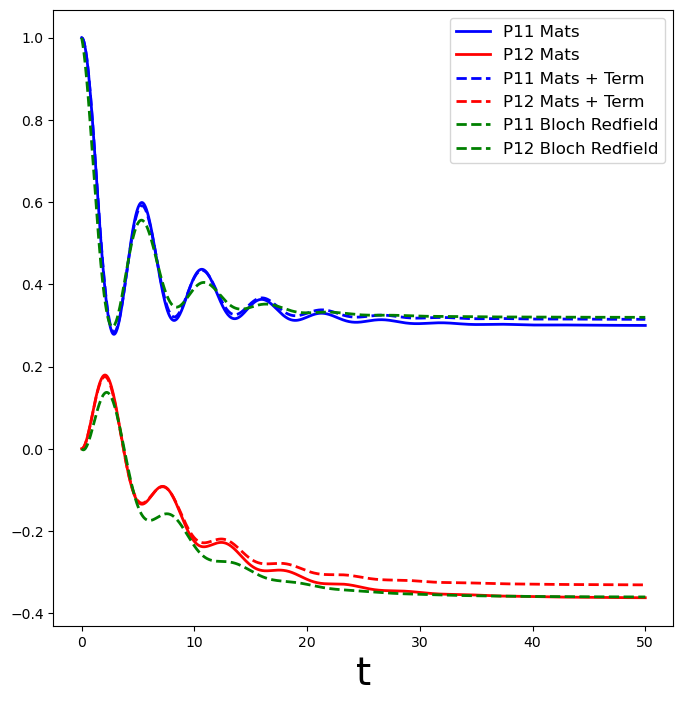

In [26]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
        (resultMatsT, P11p, "b--", "P11 Mats + Term"),
        (resultMatsT, P12p, "r--", "P12 Mats + Term"),
        (resultBR, P11p, "g--", "P11 Bloch Redfield"),
        (resultBR, P12p, "g--", "P12 Bloch Redfield"),
    ]
);

## Padé decomposition

The Matsubara decomposition is not the only option.  We can also use the
faster-converging Pade decomposition.

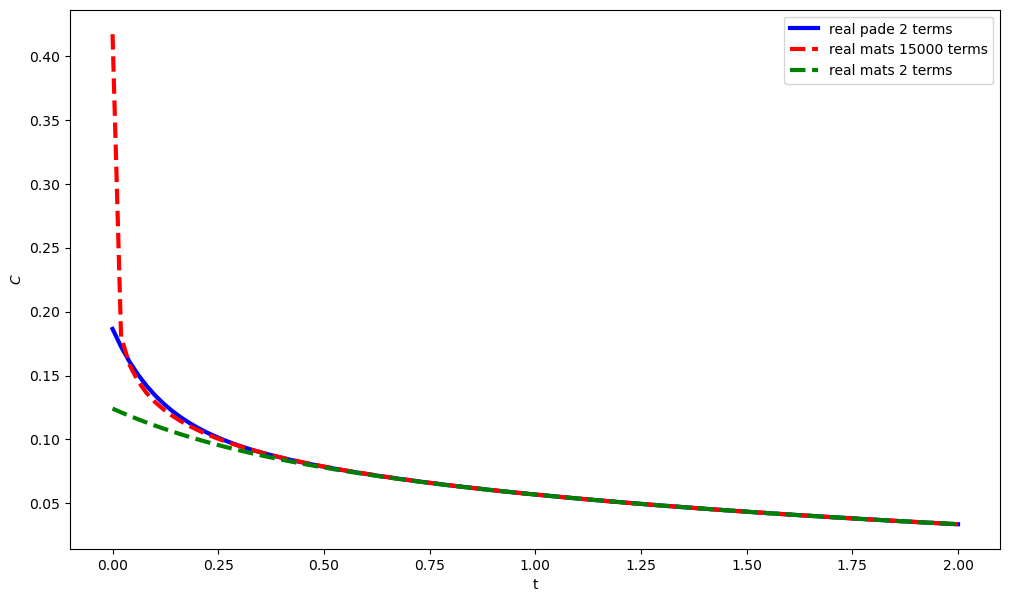

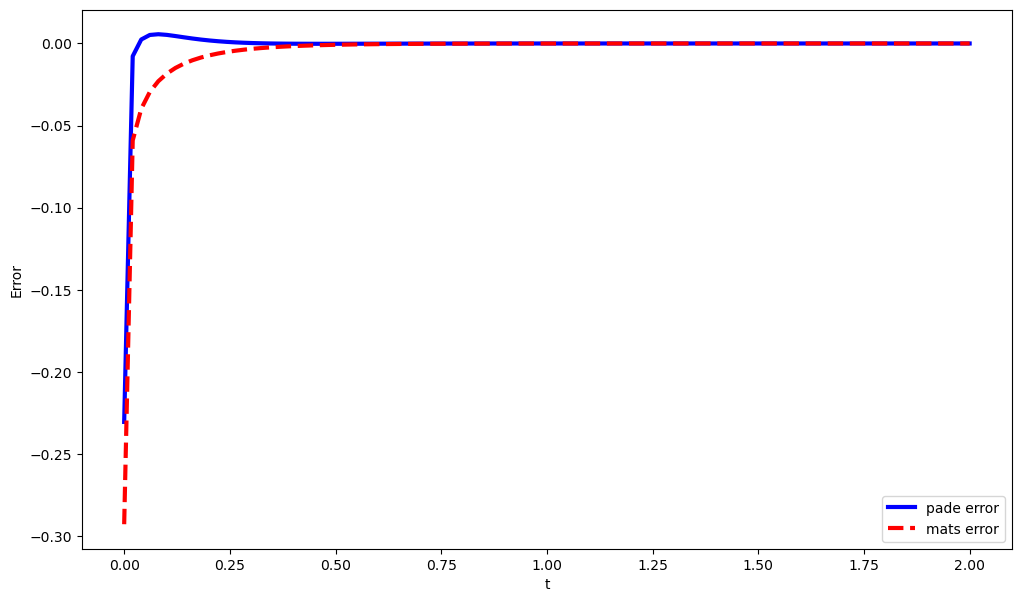

In [27]:
def deltafun(j, k):
    if j == k:
        return 1.0
    else:
        return 0.0


def pade_eps(lmax):
    Alpha = np.zeros((2 * lmax, 2 * lmax))
    for j in range(2 * lmax):
        for k in range(2 * lmax):
            # Fermionic (see other example notebooks):
            #   Alpha[j][k] = (deltafun(j, k+1) + deltafun(j, k-1))
            #                 / sqrt((2 * (j + 1) - 1) * (2 * (k + 1) - 1))
            # Bosonic:
            Alpha[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1)) / np.sqrt(
                (2 * (j + 1) + 1) * (2 * (k + 1) + 1)
            )

    eigvalsA = np.linalg.eigvalsh(Alpha)
    eps = [-2 / val for val in eigvalsA[0:lmax]]
    return eps


def pade_chi(lmax):
    AlphaP = np.zeros((2 * lmax - 1, 2 * lmax - 1))
    for j in range(2 * lmax - 1):
        for k in range(2 * lmax - 1):
            # Fermionic:
            #   AlphaP[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1))
            #                  / sqrt((2 * (j + 1) + 1) * (2 * (k + 1) + 1))
            # Bosonic [this is +3 because +1 (bose) + 2*(+1) (from bm+1)]:
            AlphaP[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1)) / np.sqrt(
                (2 * (j + 1) + 3) * (2 * (k + 1) + 3)
            )

    eigvalsAP = np.linalg.eigvalsh(AlphaP)
    chi = [-2 / val for val in eigvalsAP[0:lmax - 1]]
    return chi


def pade_kappa_epsilon(lmax):
    eps = pade_eps(lmax)
    chi = pade_chi(lmax)

    kappa = [0]
    prefactor = 0.5 * lmax * (2 * (lmax + 1) + 1)

    for j in range(lmax):
        term = prefactor
        for k in range(lmax - 1):
            term *= (chi[k] ** 2 - eps[j] ** 2) / (
                eps[k] ** 2 - eps[j] ** 2 + deltafun(j, k)
            )

        for k in range(lmax - 1, lmax):
            term /= eps[k] ** 2 - eps[j] ** 2 + deltafun(j, k)

        kappa.append(term)

    epsilon = [0] + eps

    return kappa, epsilon


def pade_corr(tlist, lmax):
    kappa, epsilon = pade_kappa_epsilon(lmax)

    eta_list = [lam * gamma * (cot(gamma * beta / 2.0) - 1.0j)]
    gamma_list = [gamma]

    if lmax > 0:
        for ll in range(1, lmax + 1):
            eta_list.append(
                (kappa[ll] / beta)
                * 4
                * lam
                * gamma
                * (epsilon[ll] / beta)
                / ((epsilon[ll] ** 2 / beta**2) - gamma**2)
            )
            gamma_list.append(epsilon[ll] / beta)

    c_tot = []
    for t in tlist:
        c_tot.append(
            sum(
                [
                    eta_list[ll] * np.exp(-gamma_list[ll] * t)
                    for ll in range(lmax + 1)
                ]
            )
        )
    return c_tot, eta_list, gamma_list


tlist_corr = np.linspace(0, 2, 100)
cppLP, etapLP, gampLP = pade_corr(tlist_corr, 2)
corr_15k = dl_corr_approx(tlist_corr, 15_000)
corr_2k = dl_corr_approx(tlist_corr, 2)

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(
    tlist_corr,
    np.real(cppLP),
    color="b",
    linewidth=3,
    label=r"real pade 2 terms",
)
ax1.plot(
    tlist_corr,
    np.real(corr_15k),
    "r--",
    linewidth=3,
    label=r"real mats 15000 terms",
)
ax1.plot(
    tlist_corr,
    np.real(corr_2k),
    "g--",
    linewidth=3,
    label=r"real mats 2 terms",
)

ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()

fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(
    tlist_corr,
    np.real(cppLP) - np.real(corr_15k),
    color="b",
    linewidth=3,
    label=r"pade error",
)
ax1.plot(
    tlist_corr,
    np.real(corr_2k) - np.real(corr_15k),
    "r--",
    linewidth=3,
    label=r"mats error",
)

ax1.set_xlabel("t")
ax1.set_ylabel(r"Error")
ax1.legend();

In [28]:
# put pade parameters in lists for heom solver
ckAR = [np.real(eta) + 0j for eta in etapLP]
ckAI = [np.imag(etapLP[0]) + 0j]
vkAR = [gam + 0j for gam in gampLP]
vkAI = [gampLP[0] + 0j]

options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMPade = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.008710622787475586
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.76s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.76s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.77s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.78s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.79s / Remaining 00:00:00:00

 Total run time:   0.79s
ODE solver time: 0.7877805233001709


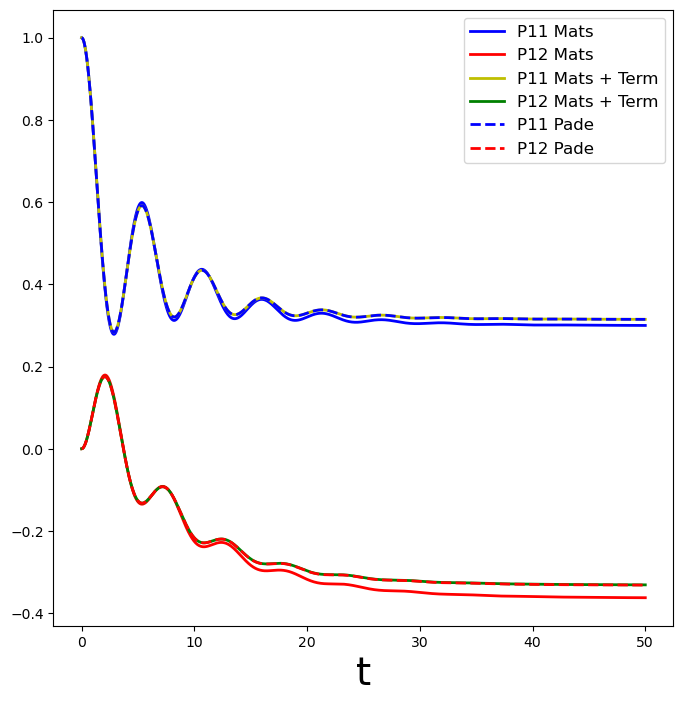

In [29]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
        (resultMatsT, P11p, "y", "P11 Mats + Term"),
        (resultMatsT, P12p, "g", "P12 Mats + Term"),
        (resultPade, P11p, "b--", "P11 Pade"),
        (resultPade, P12p, "r--", "P12 Pade"),
    ]
);

The Padé decomposition of the Drude-Lorentz bath is also available via a
built-in class, `DrudeLorentzPadeBath` bath. Like `DrudeLorentzBath`, one
can obtain the terminator by calling `bath.terminator()`.

Below we show how to use the built-in Padé Drude-Lorentz bath and its
terminator (although the terminator does not provide much improvement here,
because the Padé expansion already fits the correlation function well):

In [30]:
options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOM_dlpbath_T = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlpbath_T = HEOM_dlpbath_T.run(rho0, tlist)

RHS construction time: 0.011715888977050781
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.83s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.84s / Remaining 00:00:00:00

 Total run time:   0.84s
ODE solver time: 0.8436625003814697


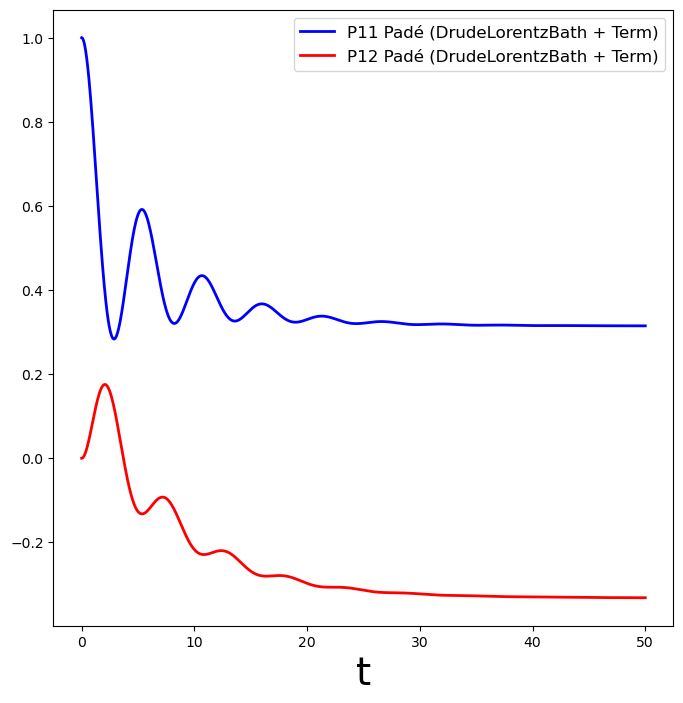

In [31]:
plot_result_expectations(
    [
        (result_dlpbath_T, P11p, "b", "P11 Padé (DrudeLorentzBath + Term)"),
        (result_dlpbath_T, P12p, "r", "P12 Padé (DrudeLorentzBath + Term)"),
    ]
);

### Next we compare the Matsubara and Pade correlation function fits

This is not efficient for this example, but can be extremely useful in
situations where large number of exponents are needed (e.g., near zero
temperature).

First we collect a large sum of Matsubara terms for many time steps:

In [32]:
tlist2 = np.linspace(0, 2, 10000)

corr_15k_t10k = dl_corr_approx(tlist2, 15_000)

corrRana = np.real(corr_15k_t10k)
corrIana = np.imag(corr_15k_t10k)

We then fit this sum with standard least-squares approach:

In [33]:
def wrapper_fit_func(x, N, args):
    """ Fit function wrapper that unpacks its arguments. """
    x = np.array(x)
    a = np.array(args[:N])
    b = np.array(args[N:2 * N])
    return fit_func(x, a, b)


def fit_func(x, a, b):
    """ Fit function. Calculates the value of the
        correlation function at each x, given the
        fit parameters in a and b.
    """
    return np.sum(
        a[:, None] * np.exp(np.multiply.outer(b, x)),
        axis=0,
    )


def fitter(ans, tlist, k):
    """ Compute fit with k exponents. """
    upper_a = abs(max(ans, key=abs)) * 10
    # sets initial guesses:
    guess = (
        [upper_a / k] * k +  # guesses for a
        [0] * k  # guesses for b
    )
    # sets lower bounds:
    b_lower = (
        [-upper_a] * k +  # lower bounds for a
        [-np.inf] * k  # lower bounds for b
    )
    # sets higher bounds:
    b_higher = (
        [upper_a] * k +  # upper bounds for a
        [0] * k  # upper bounds for b
    )
    param_bounds = (b_lower, b_higher)
    p1, p2 = curve_fit(
        lambda x, *params_0: wrapper_fit_func(x, k, params_0),
        tlist,
        ans,
        p0=guess,
        sigma=[0.01 for t in tlist],
        bounds=param_bounds,
        maxfev=1e8,
    )
    a, b = p1[:k], p1[k:]
    return (a, b)

In [34]:
kR = 4  # number of exponents to use for real part
poptR = []
with timer("Correlation (real) fitting time"):
    for i in range(kR):
        poptR.append(fitter(corrRana, tlist2, i + 1))

corrRMats = np.real(dl_corr_approx(tlist2, Nk))

kI = 1  # number of exponents for imaginary part
poptI = []
with timer("Correlation (imaginary) fitting time"):
    for i in range(kI):
        poptI.append(fitter(corrIana, tlist2, i + 1))

Correlation (real) fitting time: 0.5524570941925049
Correlation (imaginary) fitting time: 0.014220476150512695


And plot the results of the fits:

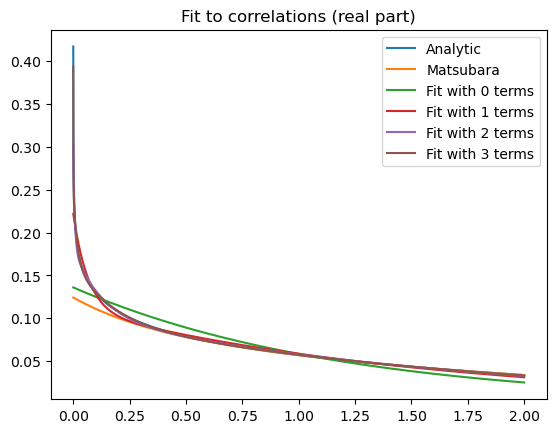

In [35]:
plt.plot(tlist2, corrRana, label="Analytic")
plt.plot(tlist2, corrRMats, label="Matsubara")

for i in range(kR):
    y = fit_func(tlist2, *poptR[i])
    plt.plot(tlist2, y, label=f"Fit with {i} terms")

plt.title("Fit to correlations (real part)")
plt.legend()
plt.show()

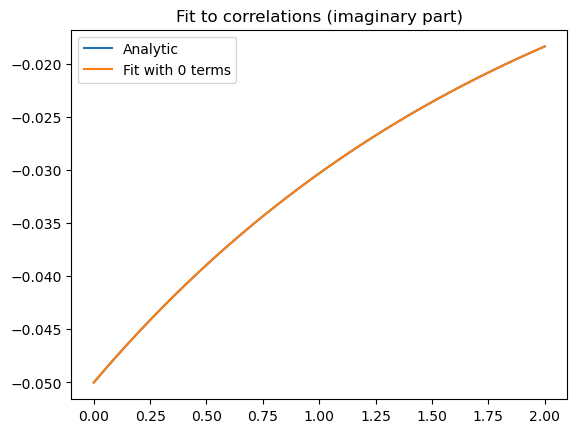

In [36]:
plt.plot(tlist2, corrIana, label="Analytic")

for i in range(kI):
    y = fit_func(tlist2, *poptI[i])
    plt.plot(tlist2, y, label=f"Fit with {i} terms")

plt.title("Fit to correlations (imaginary part)")
plt.legend()
plt.show()

In [37]:
# Set the exponential coefficients from the fit parameters

ckAR1 = poptR[-1][0]
ckAR = [x + 0j for x in ckAR1]

vkAR1 = poptR[-1][1]
vkAR = [-x + 0j for x in vkAR1]

ckAI1 = poptI[-1][0]
ckAI = [x + 0j for x in ckAI1]

vkAI1 = poptI[-1][1]
vkAI = [-x + 0j for x in vkAI1]

In [38]:
# overwrite imaginary fit with analytical value (not much reason to use the
# fit for this)

ckAI = [lam * gamma * (-1.0) + 0.0j]
vkAI = [gamma + 0.0j]

In [39]:
options = {**default_options}

NC = 4

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMFit = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.02022576332092285
 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.09s / Remaining 00:00:00:09

 [          1%           ] Elapsed 0.11s / Remaining 00:00:00:10

 [          1%           ] Elapsed 0.13s / Remaining 00:00:00:12

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.18s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.20s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:21

 [          1%           ] Elapsed 0.24s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.28s / Remaining 00:00:00:13

 [          2%           ] Elapsed 0.29s / Remaining 00:00:00:14

 [          2%           ] Elapsed 0.31s / Remaining 00:00:00:15

 [          2%           ] Elapsed 0.33s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.35s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.46s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.48s / Remaining 00:00:00:15

 [*         3%           ] Elapsed 0.50s / Remaining 00:00:00:16

 [*         3%           ] Elapsed 0.51s / Remaining 00:00:00:16

 [*         3%           ] Elapsed 0.53s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.55s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.57s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.59s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.64s / Remaining 00:00:00:15

 [*         4%           ] Elapsed 0.66s / Remaining 00:00:00:15

 [*         4%           ] Elapsed 0.68s / Remaining 00:00:00:16

 [*         4%           ] Elapsed 0.70s / Remaining 00:00:00:16

 [*         4%           ] Elapsed 0.72s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.73s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.75s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.77s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.79s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.81s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 0.83s / Remaining 00:00:00:15

 [*         5%           ] Elapsed 0.84s / Remaining 00:00:00:16

 [*         5%           ] Elapsed 0.86s / Remaining 00:00:00:16

 [*         5%           ] Elapsed 0.88s / Remaining 00:00:00:16

 [*         5%           ] Elapsed 0.90s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.92s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.94s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.95s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.97s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.99s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.01s / Remaining 00:00:00:15

 [*         6%           ] Elapsed 1.03s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.05s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.06s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.08s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.10s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.12s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.14s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.16s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.18s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.19s / Remaining 00:00:00:15

 [**        7%           ] Elapsed 1.21s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.23s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.25s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.27s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.29s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.30s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.32s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.34s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.36s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.38s / Remaining 00:00:00:15

 [**        8%           ] Elapsed 1.39s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.41s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.43s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.45s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.47s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.49s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.50s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.52s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.54s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.56s / Remaining 00:00:00:15

 [**        9%           ] Elapsed 1.58s / Remaining 00:00:00:15

 [**        9%           ] Elapsed 1.60s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.61s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.63s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.65s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.67s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.69s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.71s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.72s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.74s / Remaining 00:00:00:15

 [**       10%           ] Elapsed 1.76s / Remaining 00:00:00:15

 [**       10%           ] Elapsed 1.78s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.80s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.82s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.84s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.85s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.87s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.89s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.91s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 1.93s / Remaining 00:00:00:15

 [***      11%           ] Elapsed 1.95s / Remaining 00:00:00:15

 [***      11%           ] Elapsed 1.96s / Remaining 00:00:00:15

 [***      11%           ] Elapsed 1.98s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.00s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.02s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.04s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.06s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.07s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.11s / Remaining 00:00:00:15

 [***      12%           ] Elapsed 2.13s / Remaining 00:00:00:15

 [***      12%           ] Elapsed 2.15s / Remaining 00:00:00:15

 [***      12%           ] Elapsed 2.17s / Remaining 00:00:00:15

 [***      12%           ] Elapsed 2.18s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.20s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.22s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.24s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.26s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.28s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.29s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.31s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.33s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.35s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.37s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.39s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.40s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.42s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.44s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.46s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.48s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.50s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.51s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.53s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.55s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.57s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.59s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.61s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.63s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.64s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.66s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.68s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.70s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.72s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.74s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.75s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.77s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.79s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.81s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.83s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 2.85s / Remaining 00:00:00:14

 [****     16%           ] Elapsed 2.87s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.88s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.90s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.92s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.94s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.96s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.98s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.99s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.01s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.03s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.05s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.07s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.08s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.10s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.12s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.14s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.16s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.18s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.19s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.21s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.23s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.25s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.27s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.29s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.30s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.32s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.34s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.36s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.38s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.40s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.41s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.43s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.45s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.47s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.49s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.51s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.53s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.54s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.56s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.58s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.60s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.62s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.64s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.65s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.67s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.69s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.71s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.73s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.75s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.77s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.78s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.80s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.82s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.84s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.86s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.88s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.89s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.91s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.93s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 3.95s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 3.97s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 3.99s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.00s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.02s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.04s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.06s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.08s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.10s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.12s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.14s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.15s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.17s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.19s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.21s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.23s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.25s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.27s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.29s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.31s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.33s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.34s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.36s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.38s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.40s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.42s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.44s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.46s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.47s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.49s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.51s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.53s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.55s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.57s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.59s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.61s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.63s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.65s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.67s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.69s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.70s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.72s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.74s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.76s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.78s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.80s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.82s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.84s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.86s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.88s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.90s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.91s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.93s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.95s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.97s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 4.99s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.01s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.03s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.04s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.06s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.08s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.10s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.12s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.14s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.15s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.17s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.19s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.21s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.23s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.25s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.26s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 5.28s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 5.30s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 5.32s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.34s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.36s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.37s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.39s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.41s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.43s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.45s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.47s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.49s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.51s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.53s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.55s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.56s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.58s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.60s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.62s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.64s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.66s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.68s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.69s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.71s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.73s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.75s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.77s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.79s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.81s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.83s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.85s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.87s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.89s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.91s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.93s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.94s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.96s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 5.98s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.00s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.02s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.04s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.06s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.08s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.10s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.11s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.13s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.15s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.17s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.19s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.21s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.23s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.25s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.27s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.29s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.31s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.33s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.35s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.37s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.39s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.41s / Remaining 00:00:00:11

 [******** 35%           ] Elapsed 6.43s / Remaining 00:00:00:11

 [******** 35%           ] Elapsed 6.44s / Remaining 00:00:00:11

 [******** 35%           ] Elapsed 6.46s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.48s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.50s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.52s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.54s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.56s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.57s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.59s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.61s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.63s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.65s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.67s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.69s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.70s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.72s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.74s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 6.76s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 6.78s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.80s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.82s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.83s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.85s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.87s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.89s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.91s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.93s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 6.95s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 6.96s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 6.98s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.00s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.02s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.04s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.06s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.07s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.09s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.11s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.13s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.15s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.17s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.19s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.21s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.23s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.25s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.27s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.29s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.30s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.32s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.34s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.36s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.38s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.40s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.42s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.44s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.46s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.48s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.49s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.51s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.53s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.55s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.57s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.59s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.61s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.63s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 7.64s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.66s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.68s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.70s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 7.72s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.74s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.76s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.78s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.80s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.82s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.84s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.86s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.88s / Remaining 00:00:00:10

 [*********42%           ] Elapsed 7.90s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 7.91s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 7.93s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 7.95s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 7.97s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 7.99s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.01s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.03s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.05s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.07s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.09s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.11s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.13s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.15s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.16s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.18s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.20s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.22s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.24s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.26s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.28s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.29s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.31s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.33s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.35s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.37s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.39s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.40s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.42s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.44s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.46s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.48s / Remaining 00:00:00:09

 [*********46%           ] Elapsed 8.50s / Remaining 00:00:00:09

 [*********46%           ] Elapsed 8.51s / Remaining 00:00:00:09

 [*********46%           ] Elapsed 8.53s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.55s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.57s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.59s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.61s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.63s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.65s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.66s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.68s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.70s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.72s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.74s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.76s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.77s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.79s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.81s / Remaining 00:00:00:09

 [*********47%           ] Elapsed 8.83s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.85s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.87s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.89s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.91s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.93s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.94s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.96s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 8.98s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.00s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.02s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.04s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.06s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.07s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.09s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.11s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.13s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.15s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.16s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.18s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.20s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.22s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.24s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.26s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.27s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.29s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.31s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.33s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.35s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.37s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.39s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.40s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.42s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.44s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.46s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.48s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.50s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.51s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.53s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.55s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.57s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 9.59s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.61s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.63s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.64s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.66s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.68s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.70s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.72s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.74s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 9.75s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 9.77s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.79s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.81s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.83s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.85s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.86s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.88s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.90s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.92s / Remaining 00:00:00:08

 [*********53%           ] Elapsed 9.94s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 9.95s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 9.97s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 9.99s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.01s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.03s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.05s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.06s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.08s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.10s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.12s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.14s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.16s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.18s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.20s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.22s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.23s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.25s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.27s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.29s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.31s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.33s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.35s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.36s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.38s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.40s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.42s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.44s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.46s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.48s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.49s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.51s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.53s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.55s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.57s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.59s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.60s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 10.62s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.64s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.66s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.68s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 10.70s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.72s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.73s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.75s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.77s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.79s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.81s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.83s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.84s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 10.86s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.88s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.90s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.92s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.94s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.96s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.97s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 10.99s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.01s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.03s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.05s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.07s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.09s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.10s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.12s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.14s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.16s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.18s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.20s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.22s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.24s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.25s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.27s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.29s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.31s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.33s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.35s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.36s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.38s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.40s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.42s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.44s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.46s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.48s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.50s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.51s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.53s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.55s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.57s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.59s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.61s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 11.62s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.64s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.66s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.68s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.70s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.72s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.74s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.75s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.77s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 11.79s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.81s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.83s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.85s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.87s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.88s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.90s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.92s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.94s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.96s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 11.98s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.00s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.01s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.03s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.05s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.07s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.09s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.11s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.13s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.14s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.16s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.18s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.20s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.22s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.24s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.25s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.27s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.29s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.31s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.33s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.35s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.36s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.38s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.40s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.42s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.44s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.46s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.48s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.49s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.51s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.53s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 12.55s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.57s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.59s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.60s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.62s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.64s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.66s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.68s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.70s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 12.71s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.73s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.75s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.77s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.79s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.81s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.83s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.84s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.86s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.88s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 12.90s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 12.92s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 12.94s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 12.96s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 12.97s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 12.99s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.01s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.03s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.05s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.07s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.09s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.10s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.12s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.14s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.16s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.18s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.20s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.22s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.23s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.25s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.27s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.29s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.31s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.33s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.34s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.36s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.38s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.40s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.42s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.44s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.46s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.47s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 13.49s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 13.51s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 13.53s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.55s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.57s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.58s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.60s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.62s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 13.64s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 13.66s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.68s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.69s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.71s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.73s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.75s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.77s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.79s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.80s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 13.82s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.84s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.86s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.88s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.90s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.91s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.93s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.95s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.97s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 13.99s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.01s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.02s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.04s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.06s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.08s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.10s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.12s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.14s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.15s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.17s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.19s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.21s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.23s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.25s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.26s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.28s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.30s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.32s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.34s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.36s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.37s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.39s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.41s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.43s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.45s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.47s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.48s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.50s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.52s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.54s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 14.56s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 14.58s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.59s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.61s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.63s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.65s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.67s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.69s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.70s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.72s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 14.74s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.76s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.78s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.80s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.81s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.83s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.85s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.87s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.89s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.91s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 14.92s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 14.94s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 14.96s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 14.98s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.00s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.02s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.03s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.05s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.07s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.09s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.11s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.13s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.14s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.16s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.18s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.20s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.22s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.24s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.25s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.27s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.29s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.31s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.33s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.35s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.36s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.38s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.40s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.42s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.44s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.46s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 15.47s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 15.49s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.51s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.53s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.55s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.57s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.58s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.60s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.62s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.64s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 15.66s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.68s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.69s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.71s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.73s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.75s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.77s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.79s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.80s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.82s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 15.84s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.86s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.88s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.90s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.91s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.93s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.95s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.97s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 15.99s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.01s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.02s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.04s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.06s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.08s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.10s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.12s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.13s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.15s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.17s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.19s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.21s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.23s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.24s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.26s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.28s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.30s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.32s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.34s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.35s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.37s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 16.39s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.41s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.43s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.45s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.46s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.48s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.50s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.52s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.54s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.55s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 16.57s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 16.59s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.61s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.63s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.65s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.66s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.68s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.70s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.72s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.74s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 16.76s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.77s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.79s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.81s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.83s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.85s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.87s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.88s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.90s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.92s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 16.94s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 16.96s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 16.98s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 16.99s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.01s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.03s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.05s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.07s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.08s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.10s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.12s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.14s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.16s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.18s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.19s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.21s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.23s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.25s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.27s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.29s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 17.30s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.32s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.34s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.36s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.38s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.40s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.41s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.43s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.45s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.47s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 17.49s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 17.51s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.62s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.63s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 17.67s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.71s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.80s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 17.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.87s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 17.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.00s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.02s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.11s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.20s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 18.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.24s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.33s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.35s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.37s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 18.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 18.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 18.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 18.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 18.48s / Remaining 00:00:00:00

 [********100%***********] Elapsed 18.49s / Remaining 00:00:00:00

 Total run time:  18.50s
ODE solver time: 18.496045351028442


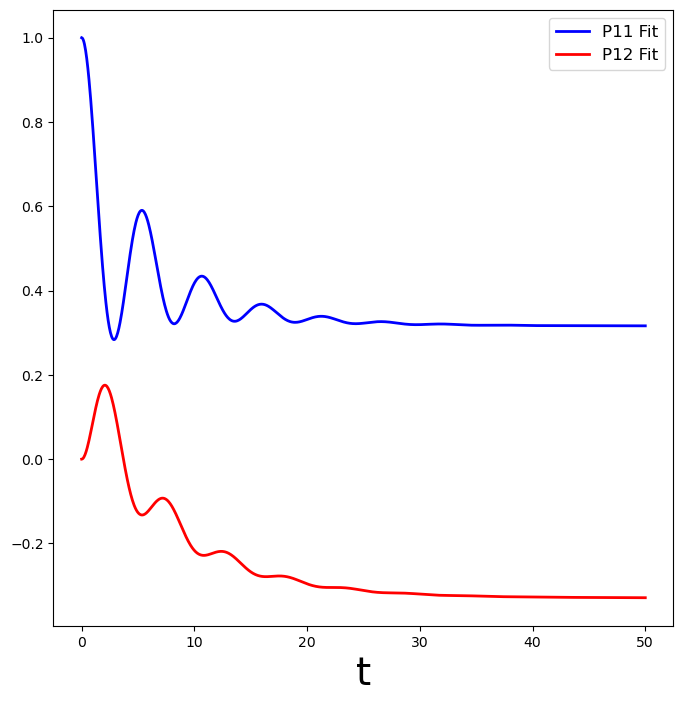

In [40]:
plot_result_expectations(
    [
        (resultFit, P11p, "b", "P11 Fit"),
        (resultFit, P12p, "r", "P12 Fit"),
    ]
);

## A reaction coordinate approach

Here we construct a reaction coordinate inspired model to capture the
steady-state behavior, and compare to the HEOM prediction. This result is
more accurate for narrow spectral densities.  We will use the population and
coherence from this cell in our final plot below.

In [41]:
dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]

gamma2 = deltaE / (2 * np.pi * gamma)
wa = 2 * np.pi * gamma2 * gamma  # reaction coordinate frequency
g = np.sqrt(np.pi * wa * lam / 2.0)  # reaction coordinate coupling
# reaction coordinate coupling factor over 2 because of diff in J(w)
# (it is 2 lam now):
g = np.sqrt(
    np.pi * wa * lam / 4.0
)  #

NRC = 10

Hsys_exp = tensor(qeye(NRC), Hsys)
Q_exp = tensor(qeye(NRC), Q)
a = tensor(destroy(NRC), qeye(2))

H0 = wa * a.dag() * a + Hsys_exp
# interaction
H1 = g * (a.dag() + a) * Q_exp

H = H0 + H1

energies, states = H.eigenstates()
rhoss = 0 * states[0] * states[0].dag()
for kk, energ in enumerate(energies):
    rhoss += states[kk] * states[kk].dag() * np.exp(-beta * energies[kk])

rhoss = rhoss / rhoss.norm()


class ReactionCoordinateResult:
    def __init__(self, states, times):
        self.states = states
        self.times = times


resultRC = ReactionCoordinateResult([rhoss] * len(tlist), tlist)

P12RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 1).dag())
P11RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 0).dag())

## Let's plot all our results

Finally, let's plot all of our different results to see how they shape up against each other.

In [42]:
rcParams = {
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28,
    "axes.grid": False,
    "savefig.bbox": "tight",
    "lines.markersize": 5,
    "font.family": "STIXgeneral",
    "mathtext.fontset": "stix",
    "font.serif": "STIX",
    "text.usetex": False,
}

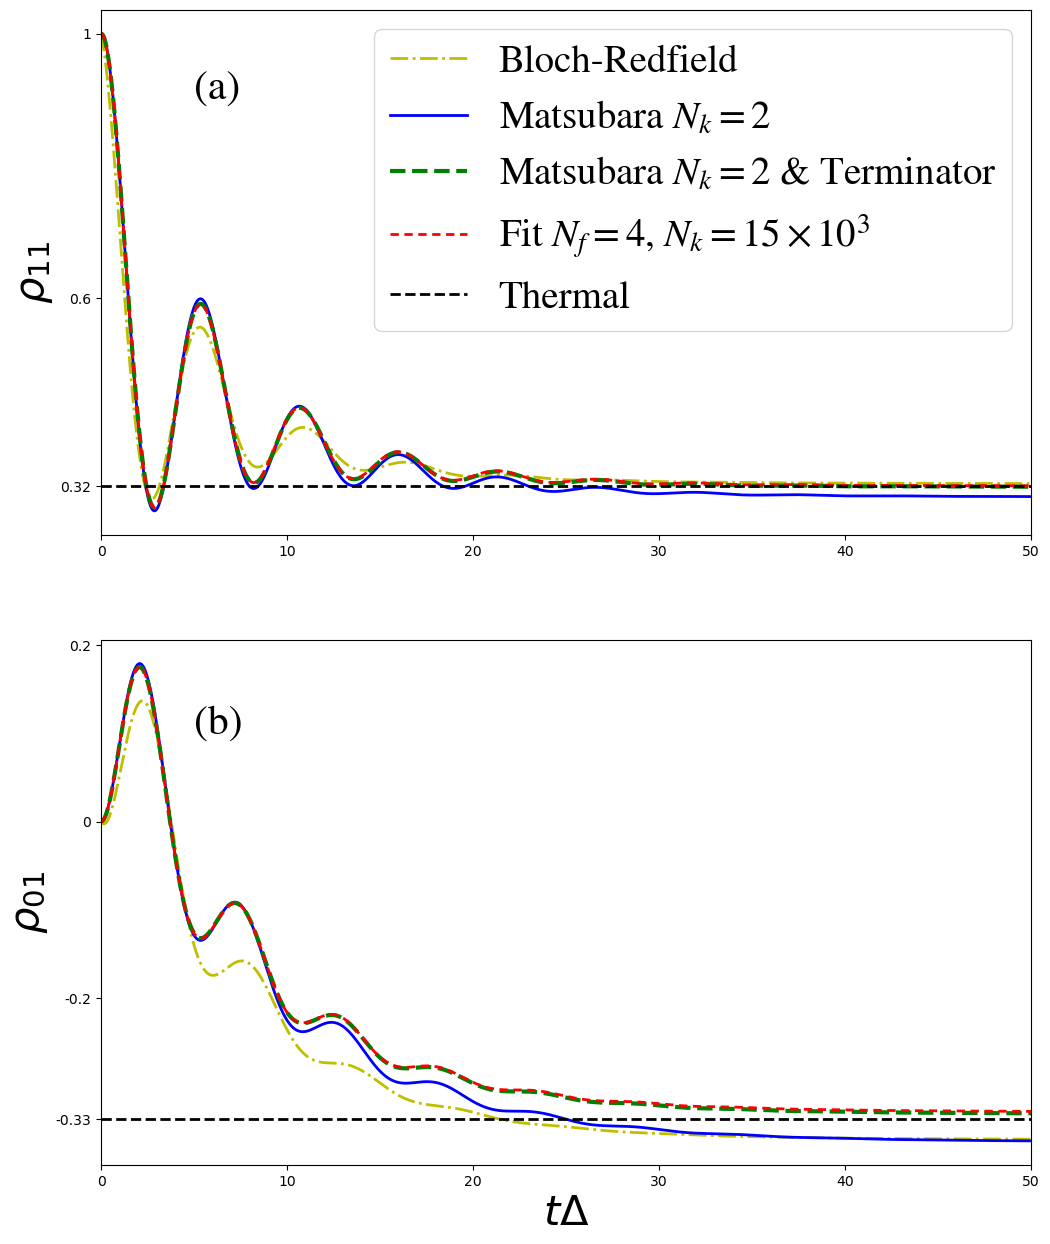

In [43]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 15))

with plt.rc_context(rcParams):

    plt.sca(axes[0])
    plt.yticks([expect(P11RC, resultRC.states[0]), 0.6, 1.0], [0.32, 0.6, 1])
    plot_result_expectations(
        [
            (resultBR, P11p, "y-.", "Bloch-Redfield"),
            (resultMats, P11p, "b", "Matsubara $N_k=2$"),
            (
                resultMatsT,
                P11p,
                "g--",
                "Matsubara $N_k=2$ & Terminator",
                {"linewidth": 3},
            ),
            (
                resultFit,
                P11p,
                "r",
                r"Fit $N_f = 4$, $N_k=15\times 10^3$",
                {"dashes": [3, 2]},
            ),
            (
                resultRC,
                P11RC,
                "--", "Thermal",
                {"linewidth": 2, "color": "black"},
            ),
        ],
        axes=axes[0],
    )
    axes[0].set_ylabel(r"$\rho_{11}$", fontsize=30)
    axes[0].legend(loc=0)
    axes[0].text(5, 0.9, "(a)", fontsize=30)
    axes[0].set_xlim(0, 50)

    plt.sca(axes[1])
    plt.yticks(
        [np.real(expect(P12RC, resultRC.states[0])), -0.2, 0.0, 0.2],
        [-0.33, -0.2, 0, 0.2],
    )
    plot_result_expectations(
        [
            (resultBR, P12p, "y-.", "Bloch-Redfield"),
            (resultMats, P12p, "b", "Matsubara $N_k=2$"),
            (
                resultMatsT,
                P12p,
                "g--",
                "Matsubara $N_k=2$ & Terminator",
                {"linewidth": 3},
            ),
            (
                resultFit,
                P12p,
                "r",
                r"Fit $N_f = 4$, $N_k=15\times 10^3$",
                {"dashes": [3, 2]},
            ),
            (
                resultRC,
                P12RC,
                "--",
                "Thermal",
                {"linewidth": 2, "color": "black"},
            ),
        ],
        axes=axes[1],
    )
    axes[1].text(5, 0.1, "(b)", fontsize=30)
    axes[1].set_xlabel(r"$t \Delta$", fontsize=30)
    axes[1].set_ylabel(r"$\rho_{01}$", fontsize=30)
    axes[1].set_xlim(0, 50)

And that's the end of a detailed first dive into modeling bosonic environments with the HEOM.

## About

In [44]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.0.dev0+afd160b
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.33
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [45]:
# Check P11p
assert np.allclose(
    expect(P11p, resultMatsT.states),
    expect(P11p, resultPade.states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, resultMatsT.states),
    expect(P11p, resultFit.states),
    rtol=1e-2,
)

# Check P12p
assert np.allclose(
    expect(P12p, resultMatsT.states),
    expect(P12p, resultPade.states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P12p, resultMatsT.states),
    expect(P12p, resultFit.states),
    rtol=1e-1,
)